In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

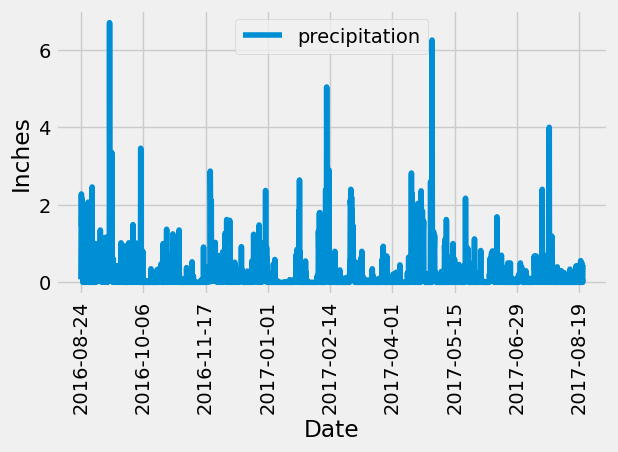

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
most_recent_datapoint = session.query(func.max(measurement.date)).scalar()
reformatted_most_recent_datapoint = dt.datetime.strptime(most_recent_datapoint, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
one_year_before = reformatted_most_recent_datapoint - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year_precipitation_scores_l = session.query(measurement.date, measurement.prcp).filter(measurement.date > 
                                                                                           one_year_before).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_precipitation_scores_df = pd.DataFrame(last_year_precipitation_scores_l,
                                                columns=['date', 'precipitation']).set_index('date').dropna()

# Sort the dataframe by date
last_year_precipitation_scores_df = last_year_precipitation_scores_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
last_year_precipitation_scores_df.plot()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_precipitation_scores_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).all()
total_stations

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations_a = session.query(measurement.station, func.count(measurement.date)).\
    group_by(measurement.station).order_by(func.sum(measurement.station).desc()).all()
sorted_most_active_stations_a = sorted(most_active_stations_a, key=lambda x: -x[1])
sorted_most_active_stations_a

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = sorted_most_active_stations_a[0][0]
temperature = measurement.tobs
query = session.query(func.min(temperature), func.max(temperature), func.avg(temperature)).filter(measurement.station == most_active_station).all()
query

[(54.0, 85.0, 71.66378066378067)]

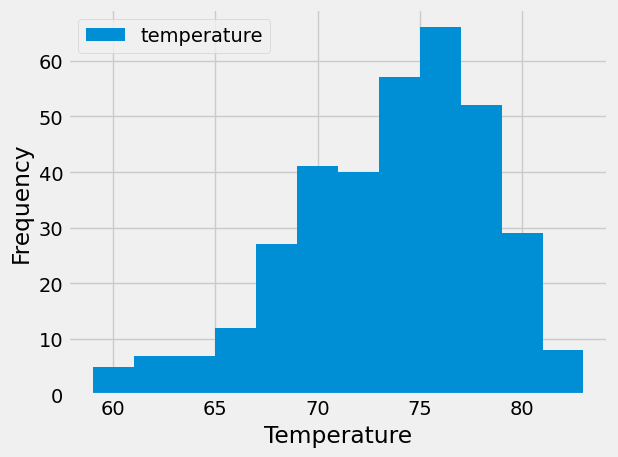

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temperature_data_most_active_station_l = session.query(measurement.date, temperature).\
    filter(measurement.date > one_year_before).filter(measurement.station == most_active_station).all()

last_year_temperature_data_most_active_station_df = pd.DataFrame(last_year_temperature_data_most_active_station_l,
                                                                columns=['date', 'temperature']).dropna()

last_year_temperature_data_most_active_station_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()